<a href="https://colab.research.google.com/github/JoDeMiro/Keras/blob/main/07_Keras_Time_series_forcasting_via_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Bevezetés a TensorFlow regresszió használatába.

Nem utolsó sorban azért készítem el ezt a notebookot mert elképesztően jó template.

In [205]:
#@title Leírás
# Ha valamilyen regresszó jellegű problémát szeretnél megoldani.
# Ami azt jelenti, hogy a bemeneti és a kimeneti válozó is folytonos, nem kategóriális.
#
# https://www.github.com
#
# Ez a kis program a regressziós problémák megoldásába nyújt bevezetést.
# Egyébként ez a kód a TensorFlow honlapjáról származik.

In [206]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Time Series prediction via regression: Value($Y_t$) -> Value($X_{t+1})$

<table class="buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/JoDeMiro/Face" /><img src="https://github.com/JoDeMiro/Data/raw/main/Bucket/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Egy nagyon érdekes kísérletet teszek. Van egy sinus hullámom és megpróbálom megbecsólni $t+1$ időpontban vett értékét $t$ és vagy $t, t-1$ időpontban vett értéke alapján.

Ha ez sikerül akkor írok egy függvényt ami az így kapott becsléseket képes a távoli jövőbe (tetszőleges $t+n$ időpontra is elvégezni.

Ha ezzel is megvagyok, akkor a következő becslésen nem csak $t+1$ időpontra, hanem egyszerre több változóra $t+1, t+2, ..., t+n$ is megkísérlem és megnézem, hogy így milyen becsléseket kapok.

[run](#run)

In [359]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make NumPy printouts easier to read.
np.set_printoptions(precision=8, suppress=True)

# Make experiment repeateable
np.random.seed(1)

In [360]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Make experiment repeatable
# tf.random.set_seed(1)

print(tf.__version__)

2.7.0


In [365]:
from keras import backend as K

if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 2.7.0 , GPU: /device:GPU:0


In [366]:
import cv2
import imutils
from google.colab.patches import cv2_imshow

## Generate Sinus function

Egyszerűen létrehozok egy sinusz függvényt. A potenciális veszély abban lenne, ha az idő alapján akarnám becsülni az értékét, hogy az idő nincs 0-1 közé normalizálva. De ebben az esetben erről nincs szó mert $Y_t = Y_{t-1}$ becslést fogok végezni, és $Y$ mindíg -1, +1 közé van normalizálva.


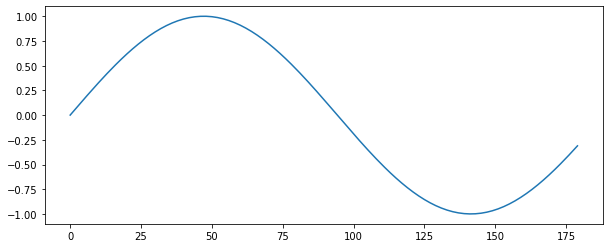

In [409]:
time = np.arange(0, 180, 1)

y = np.sin(time/30)

plt.figure(figsize=(10, 4))
plt.plot(y)
plt.show()

## Create lags and leads

In [410]:
y_len = y.shape[0]

y_1 = np.zeros(y_len)
y_1[1:y_len] = y[:-1]
y_2 = np.zeros(y_len)
y_2[2:y_len] = y[:-2]

y1  = np.zeros(y_len)
y1[0:y_len-1]  = y[1:]
y2  = np.zeros(y_len)
y2[0:y_len-2]  = y[2:]

_y  = y[2:-2]
y_1 = y_1[2:-2]
y_2 = y_2[2:-2]
y1  = y1[2:-2]
y2  = y2[2:-2]

print(y_1.shape)
print(y_2.shape)
print(y1.shape)
print(y2.shape)
print(_y.shape)

print(y[0:5])
print(_y[0:5])
print(y_1[0:5])
print(y_2[0:5])
print(y1[0:5])
print(y2[0:5])

(176,)
(176,)
(176,)
(176,)
(176,)
[0.         0.03332716 0.06661729 0.09983342 0.13293862]
[0.06661729 0.09983342 0.13293862 0.16589613 0.19866933]
[0.03332716 0.06661729 0.09983342 0.13293862 0.16589613]
[0.         0.03332716 0.06661729 0.09983342 0.13293862]
[0.09983342 0.13293862 0.16589613 0.19866933 0.23122181]
[0.13293862 0.16589613 0.19866933 0.23122181 0.26351739]


Oké tehát

```
y_1 = lag(1)
y_2 = lag(2)
y1  = lead(1)
y2  = lead(2)
_y  = y
```

Ezek alapján neki állhatunk a becslésnek.


## Becslés 1. $Y_{t} = Y_{t_1}$

In [411]:
input  = y_1
output = _y

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 1, 1

# lehet, hogy ezt majd át kell alakítani (176,1) formába

(176,)
(176,)


In [413]:
import keras

first_layer_neurons = 1
activation_function = 'sigmoid'      #--------> 'relu', 'sigmoid', 'selu' -----> https://keras.io/api/layers/activations/
loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
# model.add(keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu')) # Valahány bemenet
# model.add(keras.layers.Dense(first_layer_neurons, input_dim=n_inputs, activation=activation_function))           # Egy bemenet
# model.add(keras.layers.Dense(first_layer_neurons, input_dim=n_inputs))           # Egy bemenet
model.add(keras.layers.Input(shape=n_inputs))
# --------> last output layer
model.add(keras.layers.Dense(n_outputs))                # Valahány kimenet
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [414]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=300) # ------> batch_size = 32 (default)

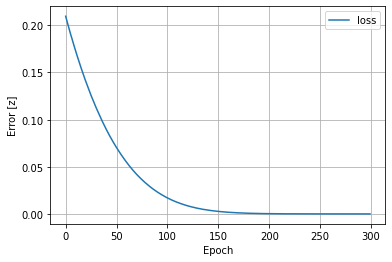

In [415]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [416]:
y_predicted = model.predict(input)

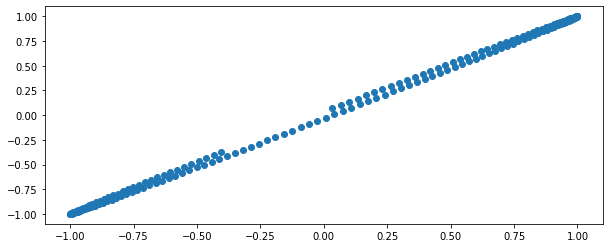

In [417]:
plt.figure(figsize=(10, 4))
plt.scatter(input, output)
plt.show()

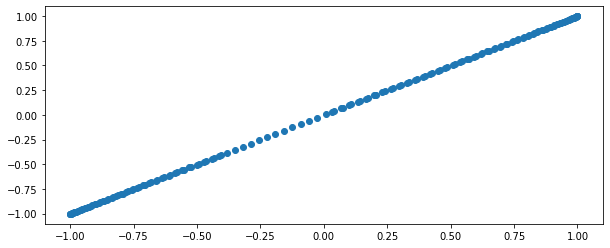

In [418]:
plt.figure(figsize=(10, 4))
plt.scatter(input, y_predicted)
plt.show()

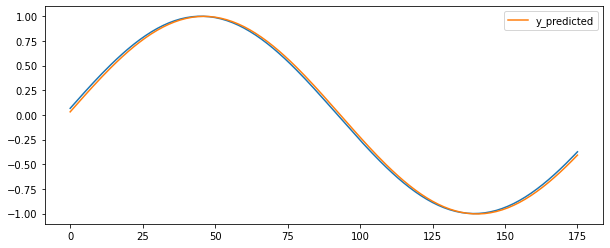

In [419]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

In [420]:
model.get_weights()

[array([[1.001136]], dtype=float32), array([-0.00233358], dtype=float32)]

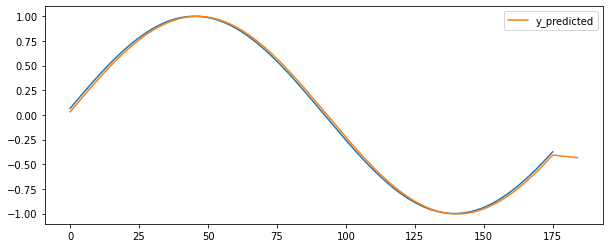

In [421]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 alapján, ezért Y_t-1 a következő becslésben Y_t lesz

foreward = 10

_input = input.copy()

for i in range(foreward):
  y_t_1_pred = model.predict(_input)
  _input = np.append(_input, y_t_1_pred[-1])

plot_result(y_t_1_pred, _y)

## Becslés 2. $Y_{t} = Y_{t_1} + Y_{t_2}$

In [422]:
input  = np.array([y_1, y_2]).T
output = _y

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 2, 1

# lehet, hogy ezt majd át kell alakítani (176,2) formába

(176, 2)
(176,)


In [438]:
import keras

first_layer_neurons = 1
activation_function = 'tanh'      #--------> 'relu', 'sigmoid', 'selu' -----> https://keras.io/api/layers/activations/
loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
# model.add(keras.layers.Dense(first_layer_neurons, input_dim=n_inputs, activation=activation_function))           # Egy bemenet
# model.add(keras.layers.Dense(first_layer_neurons, input_dim=n_inputs))                                           # linearis
model.add(keras.layers.Input(shape=n_inputs))
# --------> last output layer
model.add(keras.layers.Dense(n_outputs))                # Valahány kimenet
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [439]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=200) # ------> batch_size = 32 (default)

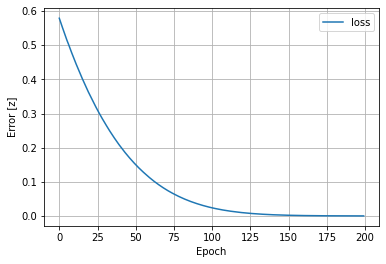

In [440]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [441]:
y_predicted = model.predict(input)

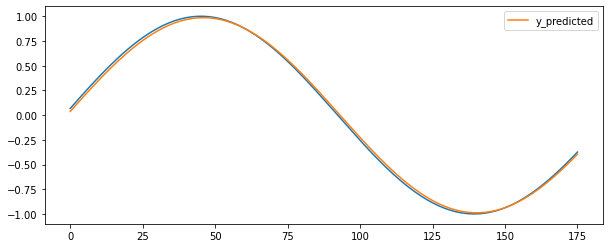

In [442]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

In [443]:
model.get_weights()

[array([[ 1.1328102 ],
        [-0.14550093]], dtype=float32), array([-0.00151404], dtype=float32)]

[-0.396557  -0.4045792]
[-0.39187124 -0.396557  ]
[-0.38773039 -0.39187124]
[-0.38372138 -0.38773039]
[-0.37978241 -0.38372138]
[-0.37590364 -0.37978241]
[-0.37208283 -0.37590364]
[-0.36831897 -0.37208283]
[-0.36461115 -0.36831897]
[-0.36095855 -0.36461115]
[-0.35736033 -0.36095855]
[-0.3538157  -0.35736033]
[-0.35032383 -0.3538157 ]
[-0.34688395 -0.35032383]
[-0.34349531 -0.34688395]
[-0.34015712 -0.34349531]
[-0.33686864 -0.34015712]
[-0.3336291  -0.33686864]
[-0.33043781 -0.3336291 ]
[-0.32729405 -0.33043781]


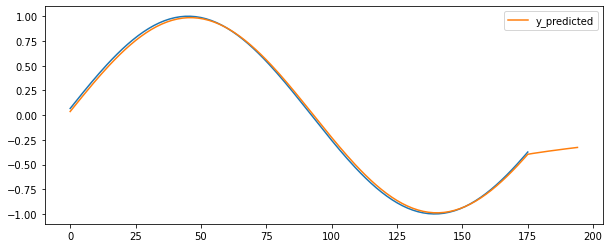

In [444]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 20

_input = input.copy()

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  __y_t_1 = y_t_1_pred[-1].flatten()
  __y_t_2 = _input[-1,0].flatten()
  __y_ins = np.array([__y_t_1, __y_t_2]).flatten()
  print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred, _y)

[-0.396557   -0.42649642]
[-0.38868228 -0.396557  ]
[-0.3841179  -0.38868228]
[-0.3800931 -0.3841179]
[-0.37619787 -0.3800931 ]
[-0.37237096 -0.37619787]
[-0.36860254 -0.37237096]
[-0.36489046 -0.36860254]
[-0.36123368 -0.36489046]
[-0.35763136 -0.36123368]
[-0.35408267 -0.35763136]
[-0.35058683 -0.35408267]
[-0.34714302 -0.35058683]
[-0.3437505  -0.34714302]
[-0.3404085 -0.3437505]
[-0.33711627 -0.3404085 ]
[-0.33387306 -0.33711627]
[-0.33067816 -0.33387306]
[-0.32753083 -0.33067816]
[-0.32443035 -0.32753083]


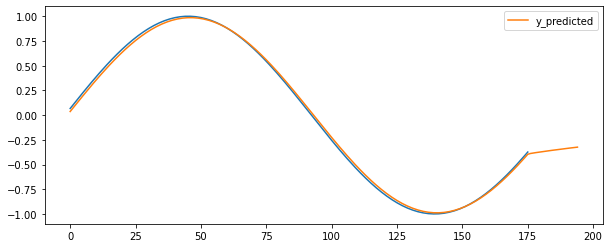

In [447]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 20

_input = input.copy()

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  __y_t_1 = y_t_1_pred[-1].flatten()
  __y_t_2 = y_t_1_pred[-2].flatten()
  __y_ins = np.array([__y_t_1, __y_t_2]).flatten()
  print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred, _y)

## Becslés 2. $Y_{t} = Y_{t_1} + Y_{t_2}$

Egy helyett két neuronnal

In [448]:
input  = np.array([y_1, y_2]).T
output = _y

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 2, 1

# lehet, hogy ezt majd át kell alakítani (176,2) formába

(176, 2)
(176,)


In [450]:
import keras

first_layer_neurons = 2
activation_function = 'tanh'      #--------> 'relu', 'sigmoid', 'selu' -----> https://keras.io/api/layers/activations/
loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
# model.add(keras.layers.Dense(first_layer_neurons, input_dim=n_inputs, activation=activation_function))           # Egy bemenet
model.add(keras.layers.Dense(first_layer_neurons, input_dim=n_inputs))           # Egy bemenet
# --------> last output layer
model.add(keras.layers.Dense(n_outputs))                # Valahány kimenet
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 2)                 6         
                                                                 
 dense_74 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [451]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=100) # ------> batch_size = 32 (default)

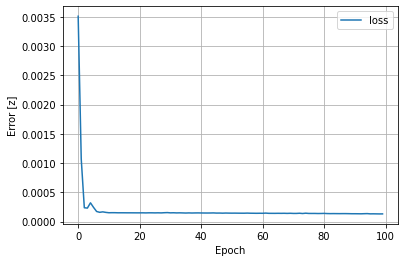

In [452]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [453]:
y_predicted = model.predict(input)

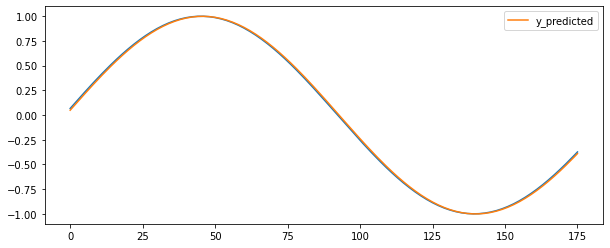

In [454]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

(176, 2)
[-0.39026731 -0.4045792 ]
[-0.3838487  -0.39026731]
[-0.38133818 -0.3838487 ]
[-0.38076255 -0.38133818]
[-0.38114461 -0.38076255]
[-0.38200048 -0.38114461]
[-0.38309065 -0.38200048]
[-0.38429645 -0.38309065]
[-0.38555908 -0.38429645]
[-0.3868494  -0.38555908]
[-0.38815305 -0.3868494 ]
[-0.38946295 -0.38815305]
[-0.39077562 -0.38946295]
[-0.39208925 -0.39077562]
[-0.39340296 -0.39208925]
[-0.39471632 -0.39340296]
[-0.39602914 -0.39471632]
[-0.39734134 -0.39602914]
[-0.39865285 -0.39734134]
[-0.39996359 -0.39865285]


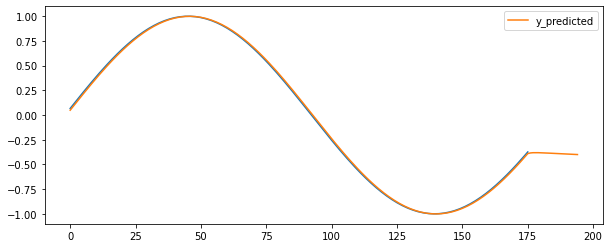

In [456]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 20

_input = input.copy()

print(_input.shape)

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  __y_t_1 = y_t_1_pred[-1].flatten()
  __y_t_2 = _input[-1,0].flatten()
#  __y_t_2 = y_t_1_pred[-2].flatten()
  __y_ins = np.array([__y_t_1, __y_t_2]).flatten()
  print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred, _y)

(176, 2)
[-0.3902673  -0.42075062]
[-0.37584567 -0.3902673 ]
[-0.36937696 -0.37584567]
[-0.3668459  -0.36937696]
[-0.3662643 -0.3668459]
[-0.3666476 -0.3662643]
[-0.36750832 -0.3666476 ]
[-0.36860508 -0.36750832]
[-0.36981836 -0.36860508]
[-0.3710889  -0.36981836]
[-0.37238747 -0.3710889 ]
[-0.37369943 -0.37238747]
[-0.37501767 -0.37369943]
[-0.37633863 -0.37501767]
[-0.37766057 -0.37633863]
[-0.37898254 -0.37766057]
[-0.38030422 -0.37898254]
[-0.3816253  -0.38030422]
[-0.38294575 -0.3816253 ]
[-0.38426542 -0.38294575]


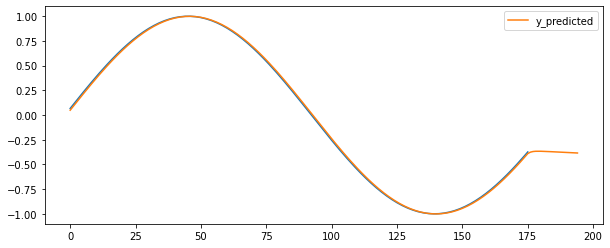

In [457]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 20

_input = input.copy()

print(_input.shape)

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  __y_t_1 = y_t_1_pred[-1].flatten()
  __y_t_2 = y_t_1_pred[-2].flatten()
  __y_ins = np.array([__y_t_1, __y_t_2]).flatten()
  print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred, _y)

## Becslés 3. $Y_{t} = Y_{t_1} + Y_{t_2} + (Y_{t_1}-Y_{t_2})$

In [476]:
diff   = y_1 - y_2
input  = np.array([y_1, y_2, diff]).T
output = _y

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 3, 1

# lehet, hogy ezt majd át kell alakítani (176,2) formába

(176, 3)
(176,)


In [477]:
input[0:5,:]

array([[0.03332716, 0.        , 0.03332716],
       [0.06661729, 0.03332716, 0.03329013],
       [0.09983342, 0.06661729, 0.03321612],
       [0.13293862, 0.09983342, 0.03310521],
       [0.16589613, 0.13293862, 0.03295751]])

In [478]:
input[30:35,:]

array([[0.85901029, 0.84147098, 0.0175393 ],
       [0.87559522, 0.85901029, 0.01658493],
       [0.89120736, 0.87559522, 0.01561214],
       [0.90582936, 0.89120736, 0.014622  ],
       [0.91944498, 0.90582936, 0.01361562]])

In [516]:
import keras

loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
model.add(keras.layers.Input(shape=n_inputs))
# --------> last output layer
model.add(keras.layers.Dense(n_outputs))                # Valahány kimenet
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [517]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=500) # ------> batch_size = 32 (default)

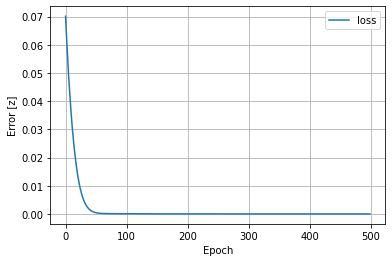

In [518]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [519]:
model.get_weights()

[array([[0.5798211 ],
        [0.41906804],
        [1.4190433 ]], dtype=float32), array([-0.00000006], dtype=float32)]

In [520]:
y_predicted = model.predict(input)

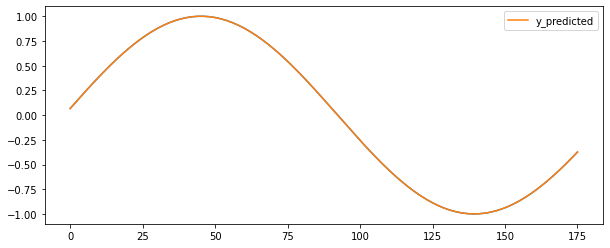

In [521]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

[-0.37387753 -0.4045801   0.03070256]
[-0.34276047 -0.37387753  0.03111705]
[-0.3112635  -0.34276047  0.03149697]
[-0.2794216 -0.3112635  0.0318419]
[-0.24727015 -0.2794216   0.03215145]
[-0.21484491 -0.24727015  0.03242524]
[-0.18218186 -0.21484491  0.03266305]
[-0.14931732 -0.18218186  0.03286454]
[-0.11628778 -0.14931732  0.03302954]
[-0.08312994 -0.11628778  0.03315784]
[-0.04988064 -0.08312994  0.0332493 ]
[-0.01657682 -0.04988064  0.03330382]
[ 0.01674454 -0.01657682  0.03332136]
[0.05004641 0.01674454 0.03330187]
[0.08329181 0.05004641 0.0332454 ]
[0.1164438  0.08329181 0.03315199]
[0.14946556 0.1164438  0.03302176]
[0.18232042 0.14946556 0.03285486]
[0.21497187 0.18232042 0.03265145]
[0.24738365 0.21497187 0.03241178]
[0.27951977 0.24738365 0.03213611]
[0.31134453 0.27951977 0.03182477]
[0.34282258 0.31134453 0.03147805]
[0.37391895 0.34282258 0.03109637]
[0.40459913 0.37391895 0.03068018]
[0.43482906 0.40459913 0.03022993]
[0.46457514 0.43482906 0.02974609]
[0.49380437 0.46457

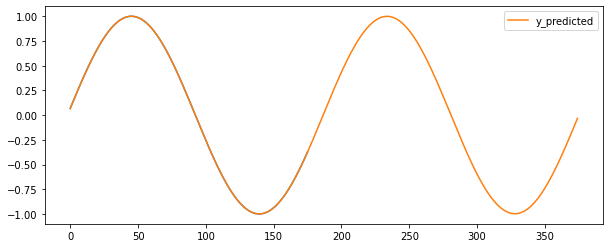

In [524]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 200

_input = input.copy()

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  __y_t_1 = y_t_1_pred[-1].flatten()
  __y_t_2 = y_t_1_pred[-2].flatten()
  __diff  = __y_t_1 - __y_t_2
  __y_ins = np.array([__y_t_1, __y_t_2, __diff]).flatten()
  print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred, _y)

## Becslés 3. $Y_{t} = Y_{t_1} + Y_{t_2} + (Y_{t_1}-Y_{t_2})$

Megismételve - csak hogy jól értem-e. Alapvető hogy ne legyen bias.

In [526]:
diff   = y_1 - y_2
input  = np.array([y_1, y_2, diff]).T
output = _y

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 3, 1

# lehet, hogy ezt majd át kell alakítani (176,2) formába

(176, 3)
(176,)


In [527]:
input[0:5,:]

array([[0.03332716, 0.        , 0.03332716],
       [0.06661729, 0.03332716, 0.03329013],
       [0.09983342, 0.06661729, 0.03321612],
       [0.13293862, 0.09983342, 0.03310521],
       [0.16589613, 0.13293862, 0.03295751]])

In [528]:
input[30:35,:]

array([[0.85901029, 0.84147098, 0.0175393 ],
       [0.87559522, 0.85901029, 0.01658493],
       [0.89120736, 0.87559522, 0.01561214],
       [0.90582936, 0.89120736, 0.014622  ],
       [0.91944498, 0.90582936, 0.01361562]])

In [529]:
import keras

loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
model.add(keras.layers.Input(shape=n_inputs))
# --------> last output layer
model.add(keras.layers.Dense(n_outputs, use_bias=False))                # Kikapcsoltam a Biast
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [530]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=500) # ------> batch_size = 32 (default)

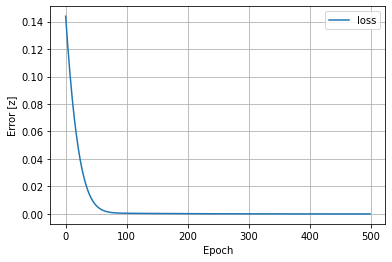

In [531]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [532]:
model.get_weights()

[array([[ 1.2182076],
        [-0.2192841],
        [ 0.7449376]], dtype=float32)]

In [533]:
y_predicted = model.predict(input)

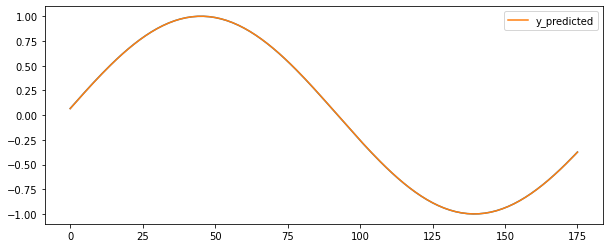

In [534]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

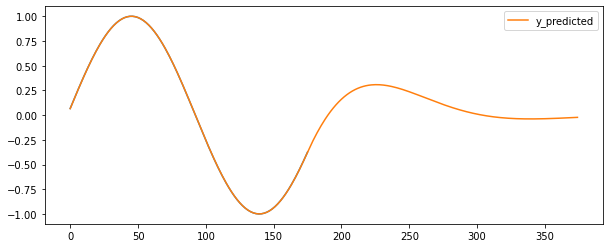

In [535]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 20

_input = input.copy()

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  __y_t_1 = y_t_1_pred[-1].flatten()
  __y_t_2 = y_t_1_pred[-2].flatten()
  __diff  = __y_t_1 - __y_t_2
  __y_ins = np.array([__y_t_1, __y_t_2, __diff]).flatten()
  # print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred, _y)

## Conclusion

Hát sajnos az látszik, hogy a Neurális háló nagyon érzékeny a kiidnuló pontra.
Hiába sikerült mindkét esetben nagyon jó illeszkedést produkálnia, ezt két különböző súlyvektorral érte el és még az első esetében jól látszik, hogy tökéletesen lefedi a valóságot amikor extrapolláltam és a jövőbeli értékeket jeleztem vele előre, a második esetben jól látszik, hogy ez nem sikerült.

Lehetséges javaslatok:
- nullára állítani a kiinduló súlyokat
- volt egy másik ötletem is de elfelejtettem
- játszani a batch_size értékével

## Most a vicc kedvéért azok a kísérletek következnek ahol $Y_{t1, t2, t3}$ időpontokat egyszerre akarom becsülni $Y_{t-1, t-2, t-3, t-n}$ alapján.

In [536]:
y_len = y.shape[0]

y_1 = np.zeros(y_len)
y_1[1:y_len] = y[:-1]
y_2 = np.zeros(y_len)
y_2[2:y_len] = y[:-2]

y1  = np.zeros(y_len)
y1[0:y_len-1]  = y[1:]
y2  = np.zeros(y_len)
y2[0:y_len-2]  = y[2:]

_y  = y[2:-2]
y_1 = y_1[2:-2]
y_2 = y_2[2:-2]
y1  = y1[2:-2]
y2  = y2[2:-2]

print(y_1.shape)
print(y_2.shape)
print(y1.shape)
print(y2.shape)
print(_y.shape)

print(y[0:5])
print(_y[0:5])
print(y_1[0:5])
print(y_2[0:5])
print(y1[0:5])
print(y2[0:5])

(176,)
(176,)
(176,)
(176,)
(176,)
[0.         0.03332716 0.06661729 0.09983342 0.13293862]
[0.06661729 0.09983342 0.13293862 0.16589613 0.19866933]
[0.03332716 0.06661729 0.09983342 0.13293862 0.16589613]
[0.         0.03332716 0.06661729 0.09983342 0.13293862]
[0.09983342 0.13293862 0.16589613 0.19866933 0.23122181]
[0.13293862 0.16589613 0.19866933 0.23122181 0.26351739]


Oké tehát

```
y_1 = lag(1)
y_2 = lag(2)
y1  = lead(1)
y2  = lead(2)
_y  = y
```

Ezek alapján neki állhatunk a becslésnek.


In [539]:
diff   = y_1 - y_2
input  = np.array([y_1, y_2, diff]).T
output = np.array([_y, y1, y2]).T

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 3, 3

# lehet, hogy ezt majd át kell alakítani (176,3) formába

(176, 3)
(176, 3)


In [541]:
input[0:5,:]

array([[0.03332716, 0.        , 0.03332716],
       [0.06661729, 0.03332716, 0.03329013],
       [0.09983342, 0.06661729, 0.03321612],
       [0.13293862, 0.09983342, 0.03310521],
       [0.16589613, 0.13293862, 0.03295751]])

In [540]:
output[30:35,:]

array([[0.87559522, 0.89120736, 0.90582936],
       [0.89120736, 0.90582936, 0.91944498],
       [0.90582936, 0.91944498, 0.93203909],
       [0.91944498, 0.93203909, 0.94359769],
       [0.93203909, 0.94359769, 0.95410795]])

In [542]:
import keras

loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
model.add(keras.layers.Input(shape=n_inputs))
# --------> last output layer
model.add(keras.layers.Dense(n_outputs, use_bias=False))                # Kikapcsoltam a Biast
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 3)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [543]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=200) # ------> batch_size = 32 (default)

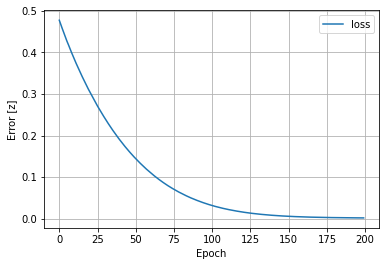

In [544]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [545]:
model.get_weights()

[array([[ 0.8890047 ,  0.7553749 , -0.2416731 ],
        [ 0.09652821,  0.24193537,  1.1983817 ],
        [ 0.05722897,  1.4271412 ,  1.426366  ]], dtype=float32)]

In [546]:
y_predicted = model.predict(input)

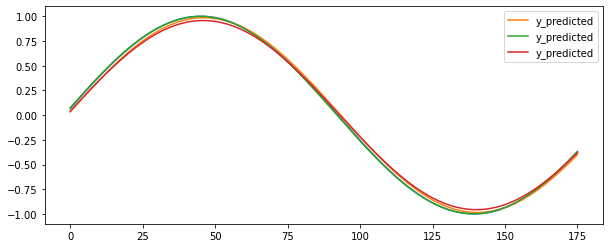

In [547]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

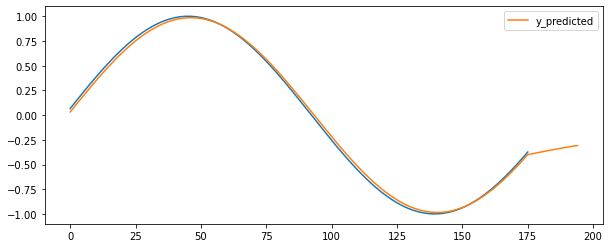

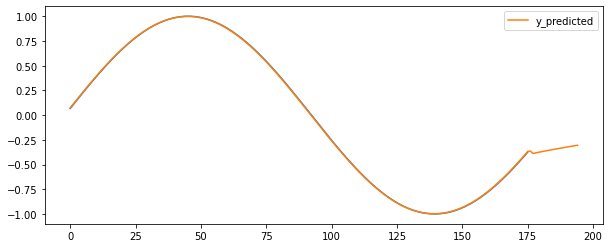

In [554]:
# Forecast

# Becsüljük Y_t érétékét Y_t-1 és Y_t-2 alapján, ezért Y_t a következő becslésben Y_t-1 lesz és Y_t-1 az Y_t-2

foreward = 20

_input = input.copy()

for i in range(foreward):
  # print(_input.shape)
  y_t_1_pred = model.predict(_input)
  y_t_1_pred_0 = y_t_1_pred[:,0]
  y_t_1_pred_1 = y_t_1_pred[:,1]
  __y_t_1 = y_t_1_pred_0[-1].flatten()
  __y_t_2 = y_t_1_pred_0[-2].flatten()
  __diff  = __y_t_1 - __y_t_2
  __y_ins = np.array([__y_t_1, __y_t_2, __diff]).flatten()
  # print(__y_ins)

  _input = np.vstack((_input, __y_ins))

plot_result(y_t_1_pred_0, _y)

## Most a vicc kedvéért azok a kísérletek következnek ahol $Y_{t1, t2, t3}$ időpontokat egyszerre akarom becsülni $Y_{t-1, t-2, t-3, t-n}$ alapján.

In [576]:
y_len = y.shape[0]

y_1 = np.zeros(y_len)
y_1[1:y_len] = y[:-1]
y_2 = np.zeros(y_len)
y_2[2:y_len] = y[:-2]

y1  = np.zeros(y_len)
y1[0:y_len-1]  = y[1:]
y2  = np.zeros(y_len)
y2[0:y_len-2]  = y[2:]
y3  = np.zeros(y_len)
y3[0:y_len-3]  = y[3:]
y4  = np.zeros(y_len)
y4[0:y_len-4]  = y[4:]
y5  = np.zeros(y_len)
y5[0:y_len-5]  = y[5:]
y6  = np.zeros(y_len)
y6[0:y_len-6]  = y[6:]
y7  = np.zeros(y_len)
y7[0:y_len-7]  = y[7:]
y8  = np.zeros(y_len)
y8[0:y_len-8]  = y[8:]
y9  = np.zeros(y_len)
y9[0:y_len-9]  = y[9:]
y10  = np.zeros(y_len)
y10[0:y_len-10]  = y[10:]

_y  = y[2:-10]
y_1 = y_1[2:-10]
y_2 = y_2[2:-10]
y1  = y1[2:-10]
y2  = y2[2:-10]
y3  = y3[2:-10]
y4  = y4[2:-10]
y5  = y5[2:-10]
y6  = y6[2:-10]
y7  = y7[2:-10]
y8  = y8[2:-10]
y9  = y9[2:-10]
y10  = y10[2:-10]

print(y_1.shape)
print(y_2.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)
print(_y.shape)

print(y[0:5])
print(_y[0:5])
print(y_1[0:5])
print(y_2[0:5])
print(y1[0:5])
print(y2[0:5])
print(y3[0:5])

(168,)
(168,)
(168,)
(168,)
(168,)
(168,)
[0.         0.03332716 0.06661729 0.09983342 0.13293862]
[0.06661729 0.09983342 0.13293862 0.16589613 0.19866933]
[0.03332716 0.06661729 0.09983342 0.13293862 0.16589613]
[0.         0.03332716 0.06661729 0.09983342 0.13293862]
[0.09983342 0.13293862 0.16589613 0.19866933 0.23122181]
[0.13293862 0.16589613 0.19866933 0.23122181 0.26351739]
[0.16589613 0.19866933 0.23122181 0.26351739 0.29552021]


In [577]:
diff   = y_1 - y_2
input  = np.array([y_1, y_2, diff]).T
output = np.array([_y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10]).T

print(input.shape)
print(output.shape)

n_inputs, n_outputs = 3, 11

# lehet, hogy ezt majd át kell alakítani (176,3) formába

(168, 3)
(168, 11)


In [578]:
import keras

loss_function = 'mse'             #--------> 'mse', 'mae'              -----> https://keras.io/api/losses/regression_losses/

# define the model
model = keras.Sequential()
# --------> first input layer
model.add(keras.layers.Input(shape=n_inputs))
# --------> last output layer
model.add(keras.layers.Dense(n_outputs, use_bias=False))                # Kikapcsoltam a Biast
model.compile(loss=loss_function, optimizer='adam')     # Mean absolute error a hibafüggvény ---------> https://keras.io/api/losses/regression_losses/

model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 11)                33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [579]:
history = model.fit(input, output, verbose=0, batch_size = 32, epochs=500) # ------> batch_size = 32 (default)

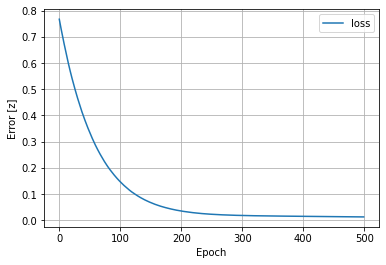

In [580]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [581]:
model.get_weights()

[array([[0.46613404, 0.8317502 , 0.5757486 , 0.5487965 , 0.5006636 ,
         0.82034016, 0.35767853, 0.53328556, 0.66829574, 0.74319166,
         0.40725377],
        [0.5327545 , 0.16660038, 0.41933993, 0.44453838, 0.48852322,
         0.16508663, 0.6219005 , 0.43985358, 0.29700762, 0.21038172,
         0.53945476],
        [1.5315347 , 1.4017797 , 2.6663823 , 2.3328226 , 2.693127  ,
         2.4489658 , 2.542542  , 2.1063924 , 2.217449  , 3.2449946 ,
         2.0840814 ]], dtype=float32)]

In [582]:
y_predicted = model.predict(input)

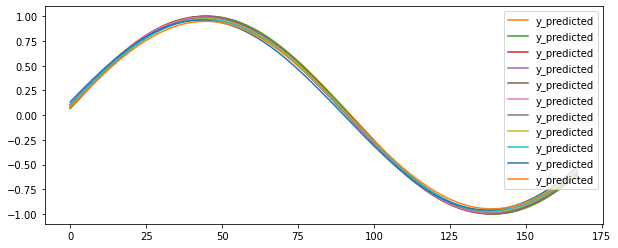

In [583]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(y_predicted, _y)

In [584]:
y_predicted.shape

(168, 11)

In [585]:
forecast = _y

forecast = np.append(forecast, y_predicted[-1,0])
forecast = np.append(forecast, y_predicted[-1,1])
forecast = np.append(forecast, y_predicted[-1,2])
forecast = np.append(forecast, y_predicted[-1,3])
forecast = np.append(forecast, y_predicted[-1,4])
forecast = np.append(forecast, y_predicted[-1,5])
forecast = np.append(forecast, y_predicted[-1,6])
forecast = np.append(forecast, y_predicted[-1,7])
forecast = np.append(forecast, y_predicted[-1,8])
forecast = np.append(forecast, y_predicted[-1,9])
forecast = np.append(forecast, y_predicted[-1,10])

forecast.shape


(179,)

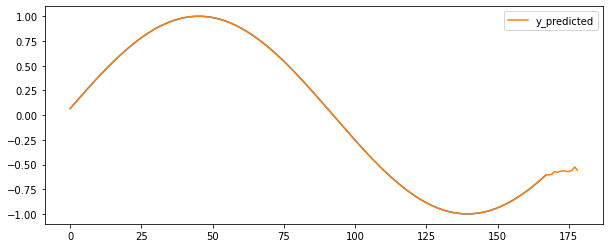

In [586]:
def plot_result(y_predicted, _y):
  plt.figure(figsize=(10, 4))
  plt.plot(_y, label = '_y')
  plt.plot(y_predicted, label = 'y_predicted')
  plt.legend()
  plt.show()

plot_result(forecast, _y)

## Conclusion

Szóval ez egy teljesen más megközelítés. Itt tulajdonképpen pont becslés történik $Y_{t_{n}}$ változókra. És a végén ebből állítok elő egy előrejelzést, de az mindíg csak olyan hosszú lehet, amenyit a model alapján megtanítottam.

## Na jó

Akkor próbálkozzunk valami egyszerűbbel - Multioutput

In [587]:
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt


# create dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)

_x = np.linspace(0, 100, 1000)
print(_x.shape)
_x0 = np.sin(_x/12)
_x1 = np.sin(_x/20)
_x2 = np.sin(_x/30)
_x3 = np.sin(_x/40)
_x4 = np.sin(_x/50)
_x5 = np.sin(_x/60)
_x6 = np.sin(_x/70)
_x7 = np.sin(_x/80)
_x8 = np.sin(_x/90)
_x9 = np.sin(_x/95)

_y0 = (_x0 + _x1 + _x2 + _x3)
_y1 = (_x0 + _x5)
_y2 = (_x5 + _x6 + _x7 + _x8 + _x9)

y = np.array([_y0, _y1, _y2]).T
X = np.array([_x0, _x1, _x2, _x3, _x4, _x5, _x6, _x7, _x8, _x9]).T

# summarize shape
print(X.shape, y.shape)

(1000,)
(1000, 10) (1000, 3)


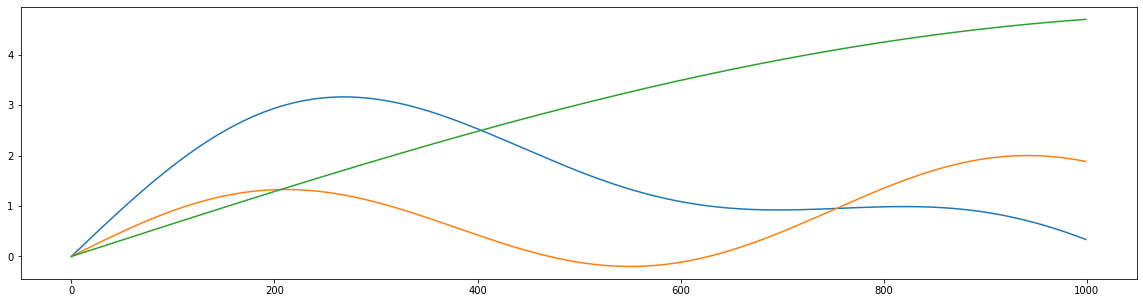

In [588]:
plt.figure(figsize=(20, 5))
plt.plot(y[:,0])
plt.plot(y[:,1])
plt.plot(y[:,2])
plt.show()

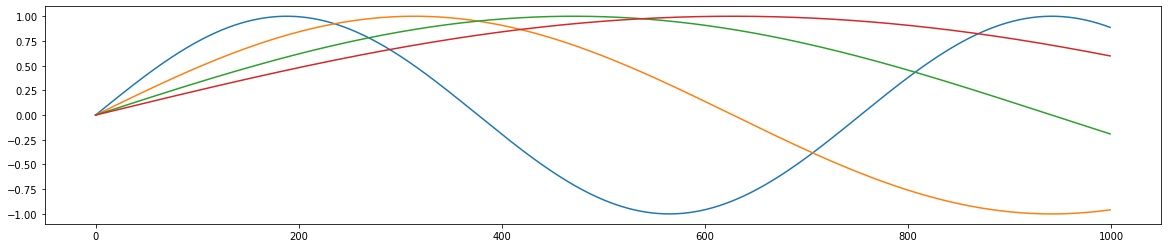

In [589]:
plt.figure(figsize=(20,4))
plt.plot(X[:,0])
plt.plot(X[:,1])
plt.plot(X[:,2])
plt.plot(X[:,3])
plt.show()

In [590]:
import keras

# define the model
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=10, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(3))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 20)                220       
                                                                 
 dense_89 (Dense)            (None, 3)                 63        
                                                                 
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


In [591]:
def get_model(n_inputs, n_outputs):
	model = keras.Sequential()
	model.add(keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(keras.layers.Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
 
	return model

In [592]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
  n_inputs, n_outputs = X.shape[1], y.shape[1]
  # define model
  model = get_model(n_inputs, n_outputs)
  # fit model
  history = model.fit(X, y, verbose=0, epochs=100)
  # evaluate model on test set
  mae = model.evaluate(X, y, verbose=0)
  # store result
  print('>%.3f' % mae)

  #model.predict

  return model

In [593]:
trained_model = evaluate_model(X,y)

>0.005


In [596]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  # plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

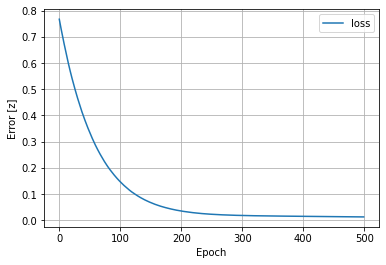

In [597]:
plot_loss(history)

In [598]:
y_predicted = trained_model.predict(X)

In [602]:
# x = tf.linspace(0.0, 150, 151)
y_predicted = trained_model.predict(X)

def plot_input_prediction_predicted(x, y_predicted):
  plt.scatter(input_feature, output_variable, label='Data')
  plt.plot(x, y_predicted, color='k', label='Predictions')
  plt.xlabel('input_feature {x_cols_width}')
  plt.ylabel('gray image pixel intesity')
  plt.legend()

(1000, 3)


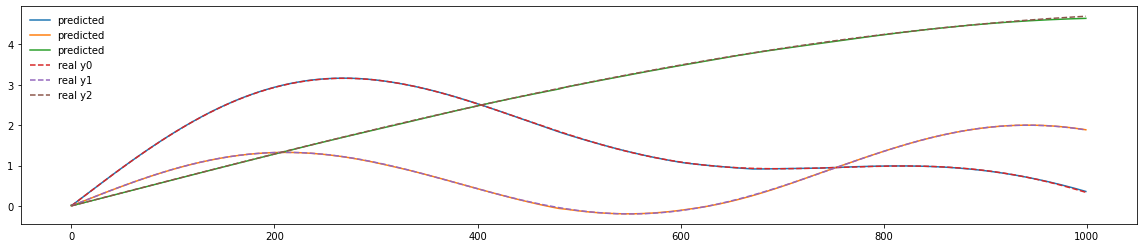

In [603]:
print(y_predicted.shape)

plt.figure(figsize=(20, 4))
plt.plot(y_predicted, label='predicted')
plt.plot(y[:,0], linestyle='dashed', label='real y0')
plt.plot(y[:,1], linestyle='dashed', label='real y1')
plt.plot(y[:,2], linestyle='dashed', label='real y2')
plt.legend(frameon = False)
plt.show()